# Deep learning and Covid-19

In this notebook, we are studying the behaviour of sars-cov 2 in the world and the some countries. Make prediction based on classification and decide the epidemiological situation in the future. To do so, we are talking about.

1. [SIRF Model with standard incidence adapted](#sirf)
2. [Practically fit data to SIRF Model](#practical)
3. [Estimate $\beta(t)$, $\gamma(t)$, $\delta(t)$](#esti)
4. [loading and Cleaning data](#clean)
5. [Exploratory data analysis](#eda)
6. [Transmission Dynamics  $\beta(t)$, $\gamma(t)$, $\delta(t)$](#comp)
7. [Making epidemiological decision](#making):
    - **Hope**:  $\beta(t) > \gamma(t)$ knowing that $\gamma(t) > \delta(t)$
    - **Danger**: $\beta(t) > \gamma(t)$ knowing that $\gamma(t) < \delta(t)$
    - **Good**:  $\beta(t) < \gamma(t)$ knowing that $\gamma(t) > \delta(t)$
    - **Apocalyse**:  $\beta(t) < \gamma(t)$ knowing that $\gamma(t) < \delta(t)$
8. [Time series analysis and new covid-19 variant detected ](#tsav)
9. [Countries classification with RNN](#clas)
10. [Conclusion](#conc)

Let's start.

<a id='sirf'></a>

# SIRF Model with standard incidence adapted

**Can we find the model that explain well the spreading of covid 19 in the world?**

We know that covid19 have many importants variables but our data, we have four:  **ConfirmedCases(TotalpositiveCases), CurrentConfirmedCases(CurrentpositiveCases), Recovered and Deaths**. How can we obtain the dynamics system equation for these variables? To answer this question, we are going to use the SIRF Model with standard incidence:

The SIRF model with standard incidence  is a classic model in epidemiology, it contain 04 subpopulations, the susceptibles **S**, the infectives **I** and recovered individuals **R**, fatalities **F**:

> Susceptiles 

> Infective

> Recovered

> Fatalities

The susceptible can become infective, and the infectives can become recovered or Fatalities, but no other transitions are considered.
The population $N = S + I + R + F$ remains constant. The model describes the movement between the classes by the system of differential equations.

$$\dfrac{dS}{dt} = -\beta I\dfrac{S}{N}$$, $$\dfrac{dI}{dt} = \beta I\dfrac{S}{N} -(\gamma +\delta) I$$, $$\dfrac{dR}{dt} = \gamma I$$ $$\dfrac{dF}{dt} = \delta I$$.  Where  $\beta$ is the transmission rate, $\gamma$ is the recovery rate, $\delta$ is fatalities rate

<a id='practical'></a>

# Practically fit data to SIRF Model

In the context of sars cov 2 in the world, we need to adapt SIRF model to our data such that we can make some approximation on behavior of disease and define transmission rate and others. If we consider **(N)**  the number of population in some fixed surface ($Km^{2}$) at time t. We know that there will exist some confirmed cases population and non confirmed cases population.

**population size = totalpositivecases + totalnegativecases** and **totalpositivecases = currentpositivecases + (recovered + death)**

hence,

**population size = totalnegativecases + currentpositivecases + recovered + death**  (1)

From (1) we can make some identification:

> population size can be a total Population tested in the surface at time t (N).

> totalnegativecases can be a Susceptible (S)

> currentpositivecases can be an Infective (I) 

> recovered + death can be a Recovered individuals (R) + Fatalities (F)

We can write again:

let's set $S_c = I+R+F$

$S = N  - S_c \rightarrow \dfrac{S}{N} = 1 - \dfrac{S_c}{N}$ if $  \dfrac{S_c}{N} << 1 $ we have $S \approx N$ and SIRF Model with standard  incidence become:

$\dfrac{dI}{dt} = (\beta - \gamma - \delta)I$, $\qquad$ $\dfrac{dR}{dt} = \gamma I$ $\qquad$ $\dfrac{dF}{dt} = \delta I$

<a id='esti'></a>

# Estimate $\beta(t)$, $\gamma(t)$, $\delta(t)$

> $\beta(t) = \dfrac{the \:  number \: of \:  daily \:  currentConfirmed \:  covid19 \:  patients \:  at \:  time \:  t}{the \:  number \:  of \:  accummulated \:  confirmed \:  covid19 \:  patients \:  at \:  time \:  t}$

> $\gamma(t) = \dfrac{the \:  number \: of \:  daily \:  recovered \:  covid19 \:  patients \:  at \:  time \:  t}{the \:  number \:  of \:  accummulated \:  confirmed \:  covid19 \:  patients \:  at \:  time \:  t}$

> $\delta(t) = \dfrac{the \:  number \: of \:  daily \:  deaths \:  covid19 \:  patients \:  at \:  time \:  t}{the \:  number \:  of \:  accummulated \:  confirmed \:  covid19 \:  patients \:  at \:  time \:  t}$

**Source: Zhien Ma, Jia Li - Dynamical Modeling and Analysis of Epidemics-World Scientific Publishing Company (2009)**

In [ ]:
# import package
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels as sm
import folium as fl
from pathlib import Path
from sklearn.impute import SimpleImputer
import geopandas as gpd
import mapclassify as mpc
import warnings
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.offline as py
import plotly.express as px
import cufflinks as cf
import tensorflow as tf
import keras

<a id='clean'></a>

# Loading and Cleaning data

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
file = []
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file.append(os.path.join(dirname, filename))
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
%matplotlib inline
pd.options.plotting.backend 
#pd.plotting.register_matplotlib_converters()
gpd.plotting.plot_linestring_collection
sns.set()
warnings.filterwarnings('ignore')
cf.go_offline()
cf.set_config_file(offline=True)

In [ ]:
data = pd.read_csv('/kaggle/input/novel-corona-virus-2019-dataset/covid_19_data.csv')

In [ ]:
data.head()

In [ ]:
data.info()

In [ ]:
data.isnull().sum()[data.isnull().sum()>0]

### Missing values imputation

In [ ]:
data = data.drop(columns=['Province/State','SNo','Last Update'])

In [ ]:
data.isnull().sum()[data.isnull().sum()>0]

### transformation data

In [ ]:
name = ["('St. Martin',)", 'Bahamas, The', 'The Bahamas', 'Congo (Brazzaville)', 'The Gambia', 'Gambia, The',
       'Cabo Verde','Mainland China', 'UK','Ireland']
replace=['St. Martin', 'Bahamas', 'Bahamas', 'Republic of the Congo', 'Gambia', 'Gambia', 'Cape Verde', 
         'China', 'United Kingdom', 'Republic of Ireland']

In [ ]:
data.replace(to_replace=name, value=replace, inplace=True)

In [ ]:
data['ObservationDate'] = pd.to_datetime(data['ObservationDate'])

In [ ]:
data.info()

In [ ]:
data["ActiveConfirmed"] = data.Confirmed - data.Recovered - data.Deaths

<a id='eda'></a>

# Exploratory data analysis

## Descriptive analysis

In [ ]:
start = data.ObservationDate.min()
end = data.ObservationDate.max()
print(f"data start {start} and end {end}.")

In [ ]:
report = data[data.ObservationDate == end]

In [ ]:
print(f"****** Daily the {end} covid19 worldwide report ******\n")
print(f"Total confirmed case: {report.Confirmed.sum()}\nTotal recovered: {report.Recovered.sum()}\nTotal deaths:\
 {report.Deaths.sum()}\nTotal Active confirmed: {data.ActiveConfirmed.sum()}")

In [ ]:
daily_cummulative = report.groupby('Country/Region')[['Confirmed','Deaths']].agg('sum')

In [ ]:
print(f"The 20 countries most affected by covid19 are:\n\n {daily_cummulative.Confirmed.sort_values(ascending=False)[:20]}")

In [ ]:
print(f"The 20 countries containing more fatalities of the covid19 are:\n\n {daily_cummulative.Deaths.sort_values(ascending=False)[:20]}")

## Visualization

In [ ]:
#we group by countries and data
grouped_data = data.groupby(['ObservationDate','Country/Region'])[['Confirmed','Recovered','Deaths','ActiveConfirmed']].agg('sum').reset_index()

In [ ]:
grouped_data.tail()

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(x='ObservationDate', y='Confirmed', hue='Country/Region', 
                data=grouped_data[grouped_data['Country/Region'].isin(['US','India','Brazil',
                                                                       'Russia','United Kingdom'])])
plt.title('Countries who are most affected by covid19.')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(x='ObservationDate', y='Deaths', hue='Country/Region', 
                data=grouped_data[grouped_data['Country/Region'].isin(['US','India','Brazil',
                                                                       'Mexico','United Kingdom'])])
plt.title('Countries who contains most fatalities of the covid19.')
plt.show()

In [ ]:
daily_cummulative.Confirmed.sort_values(ascending=False)[:20].plot(kind='bar',figsize=(15,5))
plt.title(f'20 countries more affected by Covid 19 of the {end}')
plt.ylabel('Confirmed')
plt.show()

In [ ]:
daily_cummulative.Deaths.sort_values(ascending=False)[:20].plot(kind='bar',figsize=(15,5))
plt.title(f'20 countries more injured by Covid 19 of the {end}')
plt.ylabel('Deaths')
plt.show()

<a id='comp'></a>

# Transmission Dynamics  $\beta(t)$, $\gamma(t)$, $\delta(t)$.

Here, we are determine a transmission dynamics coefficient that I was talking before see section **estimate**. 

In [ ]:
#create function which define these coef
def beta(row):
    if row['Confirmed'] == 0:
        return 0
    else:
        return row['ActiveConfirmed']/row['Confirmed']

def gamma(row):
    if row['Confirmed'] == 0:
        return 0
    else:
        return row['Recovered']/row['Confirmed']

def delta(row):
    if row['Confirmed'] == 0:
        return 0
    else:
        return row['Deaths']/row['Confirmed']

In [ ]:
grouped_data['beta'] = grouped_data.apply(beta, axis=1)
grouped_data['gamma'] = grouped_data.apply(gamma, axis=1)
grouped_data['delta'] = grouped_data.apply(delta, axis=1)

In [ ]:
transDynamics = grouped_data[['ObservationDate','Country/Region','beta','gamma','delta']]

In [ ]:
transDynamics.tail()

In [ ]:
#correlation
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
sns.heatmap(transDynamics.corr(), center=0, annot=True, fmt='.3g', ax=ax1)
sns.heatmap(transDynamics.corr(method='spearman'), center=0, annot=True, fmt='.3g', ax=ax2)
ax1.set_title('Pearson correlation')
ax2.set_title('spearman correlation')
plt.show()

We see that beta and gamma are strong opposite correlated this means that if disease increases (more transmission) then recovered decreases vis versa. It is very important for the next section.

### Compute infective rate: $\beta(t) - \gamma(t) - \delta(t)$.

In [ ]:
def infective_rate(row):
    return row['beta'] - row['gamma'] -row['delta']

In [ ]:
transDynamics['infective_rate'] = transDynamics.apply(infective_rate, axis=1)

In [ ]:
transDynamics.head()

<a id='making'></a>

# Making epidemiological decision.

To make epidemiological decision, it is just to respect this figure. 

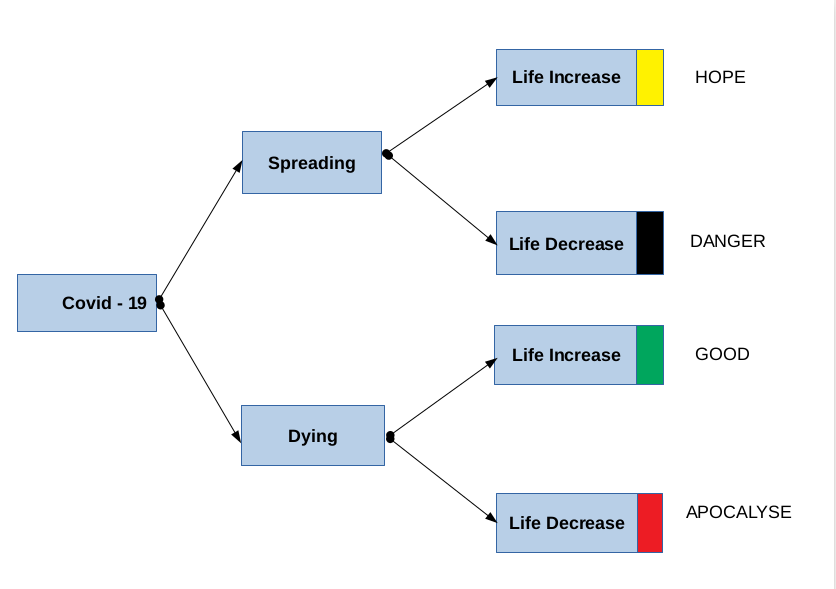

Our data have 4 decisions:
- **Hope**: Countries that have a number of active cases greater than the number of cured cases knowing that the cure rate is greater than the lethality.
- **Danger**: Countries that have a number of active cases greater than the number of cured cases knowing that the cure rate is lower than the case fatality.
- **Good**: Countries with a lower number of active cases than the number of cured cases knowing that the cure rate is greater than the lethality.
- **Apocalyse**: Countries with a lower number of active cases than the number of cured cases knowing that the cure rate is lower than the lethality.

We make also decision using:

####  Naive Bayes algorithm

we denote:
- **Spreading**: event $\beta(t) > \gamma(t)$ ( disease is spreading ) 
- **Dying**: event $\beta(t) < \gamma(t)$ (disease is dying)
- **Life Increase**: event $\delta(t) < \gamma(t)$
- **Life Decrease**: event $\delta(t) > \gamma(t)$

> $P(LifeIncrease | Spreading) = \dfrac{P(Spreading|LifeIncrease)P(LifeIncrease)}{P(Spreading)}$

> $P(LifeDecrease | Spreading) = \dfrac{P(Spreading|LifeDecrease)P(LifeDecrease)}{P(Spreading)}$

> $P(LifeIncrease | Dying) = \dfrac{P(Dying|LifeIncrease)P(LifeIncrease)}{P(Dying)}$

> $P(LifeDecrease | Dying) = \dfrac{P(Dying|LifeDecrease)P(LifeDecrease)}{P(Dying)}$

We create a function that can be make theses decisions.

In [ ]:
def decision(row):
    
    #disease spread
    if row['beta'] > row['gamma']:
        
        #life increase or decrease
        if row['gamma'] >= row['delta']:
            return 'Hope'
        else:
            return 'Danger'
        
    #disease dying
    if row['beta'] <= row['gamma']:
        
        #life increase or decrease
        if row['gamma'] >= row['delta']:
            return 'Good'
        else:
            return 'Apocalyse'

In [ ]:
transDynamics['decision'] = transDynamics.apply(decision, axis=1)

In [ ]:
transDynamics.head()

## Some visualization

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(x='ObservationDate', y='infective_rate', 
             data=transDynamics[transDynamics['Country/Region'] == 'China'], hue='decision')
plt.title('China:Epidemiological decision curve.')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
china = transDynamics[transDynamics['Country/Region'] == 'China']
sns.countplot(china.decision)
plt.title('China: Epidemiological decision ')
plt.ylabel('number of day')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(x='ObservationDate', y='infective_rate', 
             data=transDynamics[transDynamics['Country/Region'] == 'Cameroon'], hue='decision')
plt.title('Cameroun:Epidemiological decision curve.')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
cmr = transDynamics[transDynamics['Country/Region'] == 'Cameroon']
sns.countplot(cmr.decision)
plt.title('Cameroon: Epidemiological decision ')
plt.ylabel('number of day')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(x='ObservationDate', y='infective_rate', 
             data=transDynamics[transDynamics['Country/Region'] == 'France'], hue='decision')
plt.title('France:Epidemiological decision curve.')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
france = transDynamics[transDynamics['Country/Region'] == 'France']
sns.countplot(france.decision)
plt.title('France: Epidemiological decision ')
plt.ylabel('number of day')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(x='ObservationDate', y='infective_rate', 
             data=transDynamics[transDynamics['Country/Region'] == 'India'], hue='decision')
plt.title('India:Epidemiological decision curve.')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
india = transDynamics[transDynamics['Country/Region'] == 'India']
sns.countplot(india.decision)
plt.title('India: Epidemiological decision ')
plt.ylabel('number of day')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(x='ObservationDate', y='infective_rate', 
             data=transDynamics[transDynamics['Country/Region'] == 'Brazil'], hue='decision')

plt.title('Brazil:Epidemiological decision curve.')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
brazil = transDynamics[transDynamics['Country/Region'] == 'Brazil']
sns.countplot(brazil.decision)
plt.title('Brazil: Epidemiological decision ')
plt.ylabel('number of day')
plt.show()

In [ ]:
hope = transDynamics[(transDynamics.decision == 'Hope') & (transDynamics.ObservationDate == end)]
good = transDynamics[(transDynamics.decision == 'Good') & (transDynamics.ObservationDate == end)]
danger = transDynamics[(transDynamics.decision == 'Danger') & (transDynamics.ObservationDate == end)]

In [ ]:
print(f'The countries who have Hope epidemiological situation on the date {end} are:')
hope['Country/Region'].unique()

In [ ]:
print(f'The countries who have Good epidemiological situation on the date {end} are:')
good['Country/Region'].unique()

In [ ]:
print(f'The countries who have Danger epidemiological situation on the date {end} are:')
danger['Country/Region'].unique()

<a id='tsav'></a>

# Time series analysis and new covid-19 variant detected.

It was september 2020 that UK detected a new variant covid-19. Early October 2020, South Africa had dectected its variant covid19 which is different with UK. Also Brazil detected its own variant.

In this part of notebook, we are study the behaviour of new variant covid19 in UK, South Africa and Brazil, USA and India. 

## UK and new variant called B.1.1.7 

In [ ]:
uk = grouped_data[grouped_data['Country/Region'] == 'United Kingdom'].iloc[:,[0,1,2,3,4,5]]
uk_transDynamics = transDynamics[transDynamics['Country/Region'] == 'United Kingdom']

In [ ]:
uk = uk.drop(columns='Country/Region')
uk_transDynamics = uk_transDynamics.drop(columns='Country/Region')

In [ ]:
uk.tail()

In [ ]:
x1 = uk[uk.ObservationDate == '2020-07-01'].Confirmed
x2 = uk[uk.ObservationDate == '2020-09-01'].Confirmed
x3 = uk[uk.ObservationDate == '2020-10-01'].Confirmed
x4 = uk[uk.ObservationDate == '2020-12-2'].Confirmed
x5 = uk[uk.ObservationDate == '2020-11-15'].Confirmed
x6 = uk[uk.ObservationDate == '2020-12-15'].Confirmed

uk.plot(x='ObservationDate', y='Confirmed', title='confirmed case spreading in UK', figsize=(15,5))

plt.annotate(s = 'strange behaviour', xy=('2020-07-01', x1), xytext=('2020-07-01', x1+500000),
             bbox = dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(s = 'B.1.1.7 detected', xy=('2020-09-01', x2), xytext=('2020-09-01', x2+1000000),
             bbox = dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(s = 'people die more than recover', xy=('2020-10-01', x3), xytext=('2020-11-01', x3),
             bbox = dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(s = 'inflexion point', xy=('2020-12-2', x4), xytext=('2020-10-01', x4+1000000),
             bbox = dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(s = 'concave downward', xy=('2020-11-15', x5), xytext=('2020-8-15', x5+1000000),
             bbox = dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(s = 'concave upward', xy=('2020-12-15', x6), xytext=('2020-12-21', x6+1000000),
             bbox = dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

### Using maths to understand the confirmed curve in UK.

In mathematics, a **plane curve** is a curve in a plane that may be either a Euclidian plane, an affine plane, or a projective plane.

**Inflexion point** is a point on a *smooth plane curve* at which the  curvature changes sign. In particular, in the case of the graph of a function, it is a point where the function changes from being concave (concave downward) to convex (concave upward), or vice versa.

**Concave upward** is when the slope increases.
**Concave downward** is when the slope decreases.

For the graph of a function of differentiability class $C^{2}$ ($f$, its first derivative $f^{'}$, and its second derivative $f^{''}$, exist and are continuous), the condition $f^{''} = 0$ can also be used to find an **inflection point** since a point of $f^{''} = 0$ must be passed to change $f^{''}$ from a positive value (**concave upward**) to a negative value (**concave downward**) or vise versa as $f^{''}$ is continuous; an inflection point of the curve is where $f^{''} = 0$ and **changes its sign at the point (from positive to negative or from negative to positive)**.

**Extract from wikipedia**

Now, we can make analogy with our problem.

Let's $f(t)$ the function that describe the evolution of **covid 19 confirmed case**  over the time. We define $N(t)$ the function that describe the behaviour of the **incidence** such that:

$$
N(t) = \dfrac{f(t+\Delta t) - f(t)}{\Delta t}
$$ where $\Delta t$ is the periods. In our case, we take  30 days.

In [ ]:
uk['incidence'] = uk.Confirmed.diff(30)/30

In [ ]:
#we plot incidence
uk.plot(x='ObservationDate', y='incidence', title='Incidence curve', figsize=(15,5))
plt.show()

In [ ]:
uk.plot(x='ObservationDate', y='Deaths', title="Deaths", figsize=(15,5))
plt.annotate(s = 'Strange anormally', xy=('2020-08-15', 45000), xytext=('2020-06-01', 80000),
             bbox = dict(boxstyle="round", fc="0.8", color='red'),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(s = 'B.1.1.7 detected', xy=('2020-09-01', 40000), xytext=('2020-09-01',70000),
             bbox = dict(boxstyle="round", fc="0.8", color='red'),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

In [ ]:
#divide incidence in two interval
juil_2020 = uk[uk.ObservationDate < '2020-07-01']
aug_2020 = uk[uk.ObservationDate >= '2020-08-01']

In [ ]:
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(wspace=0.2)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
juil_2020.plot(x='ObservationDate', y='incidence', title='incidence curve interval I', ax=ax1)
aug_2020.plot(x='ObservationDate', y='incidence', title='incidence curve interval II', ax=ax2)

p1 = juil_2020[juil_2020.incidence == juil_2020.incidence.max()]
ax1.annotate(s = 'local maximun', xy=('2020-05-07', p1.incidence), xytext=('2020-2-21', p1.incidence),
             bbox = dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax2.annotate(s = 'global maximun', xy=('2020-11-17', 23000), xytext=('2020-10-21', 35000),
             bbox = dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax2.annotate(s = 'global minimun', xy=('2020-12-15', 18000), xytext=('2020-12-15', 10000),
             bbox = dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

We must know that:
1. **Inflection point** indicates an appearance of the covid19 wave.
2. **concave upward** indicate that incidence increases. 
3. **concaave downward** indicate that incidence decreases. 

N.B: **The number of inflection point give a number of covid19 wave**.

We are going to compute a second derivative of $f$. So, 
1. if $f^{''}(x) > 0$ we have concave upward  or convex.
2. if $f^{''}(x) < 0$ we have concave downward or concave.
3. if $f^{''}(x_{0})= 0$ in changing a sign  and $f^{'''}(x_{0}) \neq 0 $ we obtain inflection point.

hence $$
f^{''}(t) = \dfrac{N(t+\Delta t) - N(t)}{\Delta t},
$$ 

let's go for computation.

In [ ]:
uk['second_derivative'] = uk.incidence.diff(30)/30

In [ ]:
#we plot second derivative
uk.plot(x='ObservationDate', y='second_derivative', title='Second derivative curve', figsize=(15,5))
plt.hlines(0, start, end, colors='red')
plt.annotate(s = r'f"(x) > 0', xy=('2020-04-15', 150), xytext=('2020-02-15', 250),
             bbox = dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(s = r'f"(x) < 0', xy=('2020-06-15', -100), xytext=('2020-04-15', -100),
             bbox = dict(boxstyle="round", fc="0.8", color='black'),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(s = r'f"(x) > 0', xy=('2020-04-15', 150), xytext=('2020-02-15', 250),
             bbox = dict(boxstyle="round", fc="0.8", color='black'),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate(s = r'f"(x) = 0', xy=('2020-05-20', 0), xytext=('2020-05-20', 250),
             bbox = dict(boxstyle="round", fc="0.8", color='black'),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(s = r'f"(x) = 0', xy=('2020-08-01', 0), xytext=('2020-08-01', 250),
             bbox = dict(boxstyle="round", fc="0.8", color='black'),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(s = r'f"(x) = 0', xy=('2020-12-06', 0), xytext=('2020-10-11', 100),
             bbox = dict(boxstyle="round", fc="0.8", color='black'),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(s = r'f"(x) = 0', xy=('2020-12-25', 0), xytext=('2020-12-07', 200),
             bbox = dict(boxstyle="round", fc="0.8", color='black'),
            arrowprops=dict(facecolor='black', shrink=0.05))


plt.annotate(s = r'f"(x) > 0', xy=('2020-11-01', 450), xytext=('2020-11-01', 800),
             bbox = dict(boxstyle="round", fc="0.8", color='black'),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(s = r'f"(x) < 0', xy=('2020-12-15', -180), xytext=('2020-10-15', -150),
             bbox = dict(boxstyle="round", fc="0.8", color='black'),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(s = r'f"(x) > 0', xy=('2021-01-01', 400), xytext=('2020-12-01', 700),
             bbox = dict(boxstyle="round", fc="0.8", color='black'),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate(s = 'B.1.1.7 detected ', xy=('2020-09-01', 1), xytext=('2020-09-01', 400),
             bbox = dict(boxstyle="round", fc="0.8", color='green'),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.text('2020-05-01', 650, 'At 2020, 01 Sep UK detect a new variant covid19', 
         bbox=dict(facecolor='green', alpha=0.5), horizontalalignment='center',
         verticalalignment='center')

plt.show()

According to this graph, we have 4 inflections point. This means that **four covid19 wave in UK**.

Second derivative give us a growth rate of incidence.

### Phase plane

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(x='Confirmed', y='incidence', data=uk)
plt.title('Phase plane incidence-confirmed case')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(x='Confirmed', y='second_derivative', data=uk)
plt.title('Phase plane second_derivative-confirmed case')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='Deaths', y='incidence',size='Confirmed', data=uk)
plt.title('Phase plane incidence-deaths case')
plt.annotate(s = 'Strange anormally and B.1.1.7 detected', xy=(43000, 1000), xytext=(60000, 10000),
             bbox = dict(boxstyle="round", fc="0.8", color='red'),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(s = 'Speed of new cases', xy=(44000, 13000), xytext=(20000, 40000),
             bbox = dict(boxstyle="round", fc="0.8", color='red'),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

**We learn**
1. UK have 3 to 4 covid 19 wave where if possible each wave have its own new variant.
2. each new variant covid 19 increases an incidence and more deaths exists.
3. global minimun (maximun) and local mininum(maximun) of an incidence can tell us that there exist inflection point i.e new wave and new variant covid19.

### Epidemiological decision situation in UK.

In [ ]:
plt.figure(figsize=(15,10))
a1 = plt.subplot2grid((3,3),(0,0),colspan = 2)
a2 = plt.subplot2grid((3,3),(0,2), rowspan = 2, facecolor='gray')
a3 = plt.subplot2grid((3,3),(1,0),rowspan = 1, colspan = 2)

sns.countplot(x='decision', data = uk_transDynamics, ax=a2)
sns.lineplot(x='ObservationDate', y='infective_rate', data=uk_transDynamics, ax=a1)
uk_transDynamics.plot(x='ObservationDate', y=['beta', 'gamma','delta'], ax=a3)
a2.set_ylabel('number of day')
plt.show()

## South Africa and new variant called 1.351.

In [ ]:
sa = grouped_data[grouped_data['Country/Region'] == 'South Africa'].iloc[:,[0,1,2,3,4,5]]
sa_transDynamics = transDynamics[transDynamics['Country/Region'] == 'South Africa']

In [ ]:
sa = sa.drop(columns='Country/Region')
sa_transDynamics = sa_transDynamics.drop(columns='Country/Region')

In [ ]:
sa.head()

In [ ]:
sa_transDynamics.head()

In [ ]:
xp2 = sa[sa.ObservationDate == '2020-10-01'].Confirmed
xp3 = sa[sa.ObservationDate == '2020-06-15'].Confirmed
xp4 = sa[sa.ObservationDate == '2020-07-15'].Confirmed
xp5 = sa[sa.ObservationDate == '2020-08-15'].Confirmed

sa.plot(x='ObservationDate', y='Confirmed', title='confirmed case spreading in SA.', figsize=(15,5))
plt.annotate(s = '1.351 detected', xy=('2020-10-01', xp2), xytext=('2020-10-01', xp2+450000),
             bbox = dict(boxstyle="round", fc="0.8", color='red'),
            arrowprops=dict(facecolor='red', shrink=0.05))

plt.annotate(s = 'inflexion point', xy=('2020-07-15', xp4), xytext=('2020-5-01', xp4+100000),
             bbox = dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(s = 'concave ', xy=('2020-08-15', xp5), xytext=('2020-08-15', xp5+100000),
             bbox = dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(s = 'convex', xy=('2020-06-15', xp3), xytext=('2020-04-21', xp3+10000),
             bbox = dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(s = 'convex', xy=('2020-12-01', 0.8e6), xytext=('2020-12-01', 0.4e6),
             bbox = dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

### Using knowledge of maths to understand the confirmed curve in SA.

In [ ]:
sa['incidence'] = sa.Confirmed.diff(30)/30

In [ ]:
#we plot incidence
sa.plot(x='ObservationDate', y='incidence', title='Incidence curve for SA', figsize=(15,5))
plt.annotate(s = '1.351 detected', xy=('2020-10-01', 1500), xytext=('2020-10-01', 4000),
             bbox = dict(boxstyle="round", fc="0.8", color='red'),
            arrowprops=dict(facecolor='red', shrink=0.05))
plt.vlines('2020-10-01', 0, sa.incidence.max()-3300, color='black')
plt.text('2020-05-01', 12000, 'First wave', bbox=dict(facecolor='red', alpha=0.5), 
         horizontalalignment='center',
         verticalalignment='center')
plt.text('2020-12-01', 9000, 'Second wave', bbox=dict(facecolor='red', alpha=0.5), 
         horizontalalignment='center',
         verticalalignment='center')

plt.hlines(11200, '2020-08-01', '2021-01-06', linestyles='dashed', color='black')
plt.hlines(sa.incidence.max(), '2020-08-01', '2021-01-18', color='black', linestyles='dashed')

gap = f'GAP = {round(sa.incidence.max()-11200, 2)}'
plt.text('2020-09-15', 12500, gap, fontsize=18, color='red', animated=True,
         backgroundcolor='black')
plt.annotate(s = ' ', xy=('2020-08-01', sa.incidence.max()), xytext=('2020-08-01', 11000),
            arrowprops=dict(facecolor='red', shrink=0.1))
plt.text('2020-10-04',500, 'Relay zone', backgroundcolor='green', color='yellow')

plt.vlines('2020-08-01', 0, 11200, color='black', linestyles='dashed')
plt.hlines(0, '2020-05-01', '2020-08-01',color='black', linestyles='dashed')
plt.text('2020-07-05', 2000, '4 months\n to reach\n the peak\n epidemic',
        fontsize=12, color='red', animated=True,
         backgroundcolor='gray')
plt.vlines('2021-01-18', 5, sa.incidence.max(), color='black', linestyles='dashed')
plt.hlines(1500, '2020-11-11', '2021-01-18',color='black', linestyles='dashed')
plt.text('2020-12-23', 2000, '2 months\n to reach\n the peak\n epidemic',
         fontsize=12, color='red', animated=True,
         backgroundcolor='gray')


plt.show()

In [ ]:
sa.plot(x='ObservationDate', y='Deaths', title="Deaths", figsize=(15,5))
plt.show()

In [ ]:
sa['new_deaths_per_month'] = sa.Deaths.diff(30)/30

In [ ]:
sa.plot(x='ObservationDate', y='new_deaths_per_month', title="new deaths per day", figsize=(15,5))
plt.show()

In [ ]:
sa.corr()

In [ ]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='incidence', y='new_deaths_per_month', data=sa)
plt.title('Covid 19 Phase plane for SA.')
plt.show()

### Epidemiological decision situation in SA.

In [ ]:
plt.figure(figsize=(15,10))
as1 = plt.subplot2grid((3,3),(0,0),colspan = 2)
as2 = plt.subplot2grid((3,3),(0,2), rowspan = 2, facecolor='gray')
as3 = plt.subplot2grid((3,3),(1,0),rowspan = 1, colspan = 2)

sns.countplot(x='decision', data = sa_transDynamics, ax=as2)
sns.lineplot(x='ObservationDate', y='infective_rate', data=sa_transDynamics, ax=as1)
sa_transDynamics.plot(x='ObservationDate', y=['beta', 'gamma','delta'], ax=as3)
as2.set_ylabel('number of day')
plt.show()

**We learn**
1. South Africa have two waves of covid19 where the second wave contains a new variant 1.351.
2. Between two peak epidemics, there exist a zone called relay zone (transition of two states).
3. new variant 1.351 spread very fast; only two months to reach the peak epidemic and more deaths occurs.
4. the epidemiological decision situation is not bad.

## Brazil and new variant called P.1

In [ ]:
bz = grouped_data[grouped_data['Country/Region'] == 'Brazil'].iloc[:,[0,1,2,3,4,5]]
bz_transDynamics = transDynamics[transDynamics['Country/Region'] == 'Brazil']

In [ ]:
bz = bz.drop(columns='Country/Region')
bz_transDynamics = bz_transDynamics.drop(columns='Country/Region')

In [ ]:
bz.head()

In [ ]:
bz_transDynamics.head()

In [ ]:
bz.plot(x='ObservationDate', y='Confirmed', title='confirmed case spreading in BZ.', figsize=(15,5))
plt.annotate(s = 'P.1 detected', xy=('2020-12-01', 6.5e6), xytext=('2020-12-01', 8e6),
             bbox = dict(boxstyle="round", fc="0.8", color='red'),
            arrowprops=dict(facecolor='red', shrink=0.05))
plt.show()

### Understand covid 19 confirmed in BZ.

In [ ]:
bz['incidence'] = bz.Confirmed.diff(30)/30

In [ ]:
bz.plot(x='ObservationDate', y='incidence', title='Incidence curve for BZ', figsize=(15,5))
plt.annotate(s = 'P.1 detected', xy=('2020-12-01', 30000), xytext=('2020-12-01', 4000),
             bbox = dict(boxstyle="round", fc="0.8", color='red'),
            arrowprops=dict(facecolor='red', shrink=0.05))
plt.show()

In [ ]:
bz.plot(x='ObservationDate', y='Deaths', title="Deaths", figsize=(15,5))
plt.show()

In [ ]:
bz['new_deaths_per_day'] = bz.Deaths.diff(30)/30

In [ ]:
bz.plot(x='ObservationDate', y='new_deaths_per_day', title="new deaths per day", figsize=(15,5))
plt.show()

In [ ]:
bz.corr()

In [ ]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='incidence', y='new_deaths_per_day', data=bz)
plt.title('Covid 19 Phase plane for BZ.')
plt.show()

### Epidemiological decision situation in BZ

In [ ]:
plt.figure(figsize=(15,10))
ab1 = plt.subplot2grid((3,3),(0,0),colspan = 2)
ab2 = plt.subplot2grid((3,3),(0,2), rowspan = 2, facecolor='gray')
ab3 = plt.subplot2grid((3,3),(1,0),rowspan = 1, colspan = 2)

sns.countplot(x='decision', data = bz_transDynamics, ax=ab2)
sns.lineplot(x='ObservationDate', y='infective_rate', data=bz_transDynamics, ax=ab1)
bz_transDynamics.plot(x='ObservationDate', y=['beta', 'gamma','delta'], ax=ab3)
ab2.set_ylabel('number of day')
plt.show()

**We learn**
1. The behaviour of P.1 begins before 2020, 1 Dec.

# Countries classification with RNN

In this section, we are using rnn to classifier countries about its epidemiological decision situation.

In [ ]:
transDynamics.corr()

In [ ]:
cdata = transDynamics[['ObservationDate', 'beta', 'delta']]
label = transDynamics['decision']

In [ ]:
cdata.set_index('ObservationDate', inplace=True)

In [ ]:
cdata.head()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
enc_label = LabelEncoder()
target = enc_label.fit_transform(label)

In [ ]:
enc_label.classes_

In [ ]:
target.shape

In [ ]:
sns.countplot(label)
plt.show()

In [ ]:
label.value_counts()

## To be continue....